Hamidreza Yaghoubi Araghi 98109786

Alireza Heidari 98109731

Ali Mehrabani 98109753

Mohammad Khodadadi 98106434

# Initialize

## Import

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import seaborn as sns
from bioinfokit.visuz import cluster
import warnings

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pyspark.sql import SparkSession, Row, functions as F 

## Config

In [2]:
SAMPLE_FILE_NUMBER = [1, 2, 3]
DATA_PATH_FROMAT = './MQ2007/S{}.txt'
DATA_PATHS = [DATA_PATH_FROMAT.format(number) for number in SAMPLE_FILE_NUMBER]

TEST_SIZE = 0.20
FEATURE_COUNT = 46
warnings.filterwarnings('ignore')

RADNOM_STATE = 42

## Spark

In [3]:
SPARK_THREADS = 12
SPARK_MEMORY = 8
CHECKPOINT_DIR = os.path.expanduser('~/tmp/spark_checkpoint') 

In [4]:
spark = (
    SparkSession 
    .builder 
    .master("local[{}]".format(SPARK_THREADS)) 
    .config("spark.driver.memory", "{}g".format(SPARK_MEMORY),)
    .config('spark.sql.session.timeZone', 'Asia/Tehran')
    .getOrCreate()
)

sc = spark.sparkContext
sc.setCheckpointDir(CHECKPOINT_DIR)

## Plot

In [5]:
FIGSIZE = (13, 9)

## Ohter

In [6]:
def summery(pdf):
    display(pdf.head(5))

# Data Preparation

## Load Data

In [7]:
def load_raw_data_pdf(data_paths):
    train_data_pdf = []
    for path in data_paths:
        train_data_pdf.append(pd.read_csv(path, sep=" ", header=None))
    return pd.concat(train_data_pdf).reset_index(drop=True)

raw_data_pdf = load_raw_data_pdf(DATA_PATHS)
summery(raw_data_pdf)

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,0,qid:10,1:0.000000,2:0.000000,3:0.000000,4:0.000000,5:0.000000,6:0.000000,7:0.000000,8:0.000000,...,46:0.000000,#docid,=,GX000-00-0000000,inc,=,1.000000,prob,=,0.024691
1,1,qid:10,1:0.031310,2:0.666667,3:0.500000,4:0.166667,5:0.033206,6:0.000000,7:0.000000,8:0.000000,...,46:0.000000,#docid,=,GX000-24-12369390,inc,=,0.600319,prob,=,0.416367
2,1,qid:10,1:0.078682,2:0.166667,3:0.500000,4:0.333333,5:0.080022,6:0.000000,7:0.000000,8:0.000000,...,46:0.000000,#docid,=,GX000-62-7863450,inc,=,1.000000,prob,=,0.568950
3,1,qid:10,1:0.019058,2:1.000000,3:1.000000,4:0.500000,5:0.022591,6:0.000000,7:0.000000,8:0.000000,...,46:0.000000,#docid,=,GX016-48-5543459,inc,=,1.000000,prob,=,0.775913
4,0,qid:10,1:0.039477,2:0.000000,3:0.750000,4:0.166667,5:0.040555,6:0.000000,7:0.000000,8:0.000000,...,46:0.000000,#docid,=,GX037-87-3082362,inc,=,0.588907,prob,=,0.334800


## Data Cleaning

In [8]:
def remove_unsued_info(pdf):
    return pdf.iloc[: , :-9]

def remove_column_name_from_data(pdf):
    for i in range(1, 48):
        pdf[['temp', i]] = pdf[i].str.split(':', expand=True)
    pdf = pdf.drop('temp', axis=1)
    return pdf
    
def rename_lable_and_id(pdf):
    pdf = pdf.rename(columns = {1:'qid', 0:'label'})
    for i in range(2, 48):
        pdf = pdf.rename(columns = {i:i-1})
        
    return pdf

data_pdf = remove_unsued_info(raw_data_pdf)
data_pdf = remove_column_name_from_data(data_pdf)
data_pdf = rename_lable_and_id(data_pdf)
summery(data_pdf)

,label,qid,1,2,3,4,5,6,7,8,...,37,38,39,40,41,42,43,44,45,46
0,0,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000
1,1,10,0.031310,0.666667,0.500000,0.166667,0.033206,0.000000,0.000000,0.000000,...,0.646890,0.686107,0.823908,0.750092,0.385426,0.923077,0.086207,0.333333,0.448276,0.000000
2,1,10,0.078682,0.166667,0.500000,0.333333,0.080022,0.000000,0.000000,0.000000,...,0.649824,0.578581,0.868557,0.641385,0.010462,0.076923,0.074713,0.833333,0.678161,0.000000
3,1,10,0.019058,1.000000,1.000000,0.500000,0.022591,0.000000,0.000000,0.000000,...,0.918403,0.868457,1.000000,0.863460,0.016642,0.153846,0.040230,0.833333,0.896552,0.000000
4,0,10,0.039477,0.000000,0.750000,0.166667,0.040555,0.000000,0.000000,0.000000,...,0.565875,0.569440,0.769845,0.646567,0.073711,0.076923,0.034483,0.333333,0.218391,0.000000


## Split X and Y

In [9]:
x_pdf = data_pdf.drop('label', axis=1)
y_pdf = data_pdf[['qid', 'label']]
summery(x_pdf)

,qid,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000
1,10,0.031310,0.666667,0.500000,0.166667,0.033206,0.000000,0.000000,0.000000,0.000000,...,0.646890,0.686107,0.823908,0.750092,0.385426,0.923077,0.086207,0.333333,0.448276,0.000000
2,10,0.078682,0.166667,0.500000,0.333333,0.080022,0.000000,0.000000,0.000000,0.000000,...,0.649824,0.578581,0.868557,0.641385,0.010462,0.076923,0.074713,0.833333,0.678161,0.000000
3,10,0.019058,1.000000,1.000000,0.500000,0.022591,0.000000,0.000000,0.000000,0.000000,...,0.918403,0.868457,1.000000,0.863460,0.016642,0.153846,0.040230,0.833333,0.896552,0.000000
4,10,0.039477,0.000000,0.750000,0.166667,0.040555,0.000000,0.000000,0.000000,0.000000,...,0.565875,0.569440,0.769845,0.646567,0.073711,0.076923,0.034483,0.333333,0.218391,0.000000


# EDA

In this section, first we visualize features using t-SNE then we want to see if using the PCA algorithm is good to reduce the number of features for the training process. As usual and comen, we first normalized data and then used the PCA algorithm on the normalized data.

## Normalize Data

In [10]:
sc = StandardScaler()
norm_data_pdf = sc.fit_transform(x_pdf.drop('qid', axis=1))

## t-SNE

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


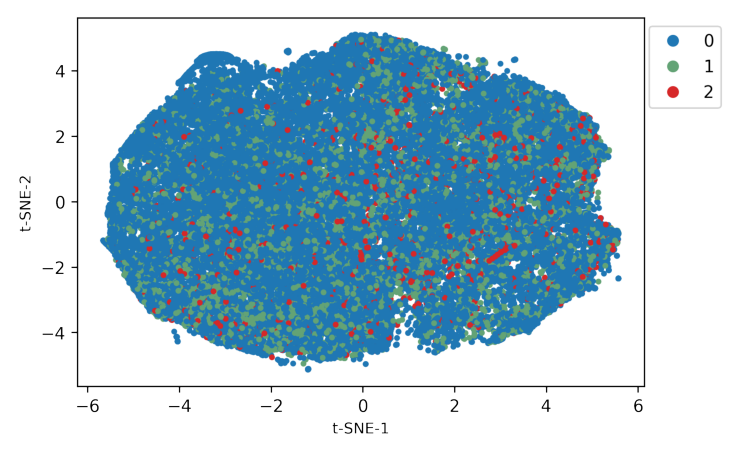

In [11]:
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=300, init='pca').fit_transform(norm_data_pdf)
color_class = y_pdf['label'].to_numpy()
cluster.tsneplot(score=tsne_em, colorlist=color_class, colordot=('tab:blue', '#63a375', 'tab:red'), 
    legendpos='upper right', legendanchor=(1.15, 1) )

fig, ax = plt.subplots(figsize=FIGSIZE)
image = mpimg.imread('./tsne_2d.png')
plt.imshow(image)
plt.axis('off') 
plt.show()

## Effectivenes of PCA

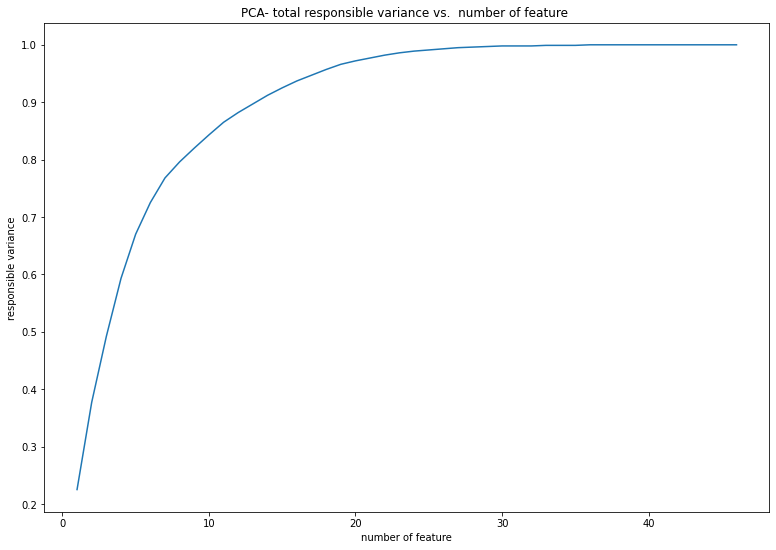

In [12]:
number_of_feature = []
responsible_variance = []
for i in range(1, len(norm_data_pdf[0]) + 1):
    pca = PCA(n_components=i)
    X_train = pca.fit_transform(norm_data_pdf)
    explained_variance = pca.explained_variance_ratio_
    responsible_variance.append(round(sum(explained_variance), 3))
    number_of_feature.append(i)
    
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.plot(number_of_feature, responsible_variance)
plt.title('PCA- total responsible variance vs.  number of feature ')
plt.ylabel('responsible variance')
plt.xlabel('number of feature')
plt.show()

<font color='Red'>
    <div style=style="font-size: 25px"> 
        Result
    </div>
</font>

As you can see above, we can use 30 features with a nearly total responsible variance of 1 instead of all 46 features. This reduction of features and the known fact that Normalization and PCA will help us to avoid sparsity problems in classification, will lead us to use the Normalization and PCA algorithm. 

As a result, <font color='Green'> we will use the PCA algorithm with n_components=30 </font>.

## Impcat of PCA on Sparsity

As the most of features suffer from sparsity, reducing unnecessary features will have a huge impact to overcome sparsity as far as we can. In this section, we show that Normalization and PCA will help reduce the sparsity of data.

In [13]:
def calculate_sparsity(pdf, feature_count):
    coutn_of_all_data = len(pdf) * feature_count
    count_of_zero_data = 0
    for column in pdf.columns:
        count_of_zero_data += len(pdf[pdf[column] == '0.000000'][column])
    return round(count_of_zero_data / coutn_of_all_data, 2)

In [14]:
pca = PCA(n_components=30)
redeuced_norm_data_pdf = pca.fit_transform(norm_data_pdf)
redeuced_norm_data_pdf = pd.DataFrame(redeuced_norm_data_pdf)

In [15]:
print(f"Precent of zero data befor Normalization and PCA = {calculate_sparsity(x_pdf, 46)}")
print(f"Precent of zero data after Normalization and PCA = {calculate_sparsity(redeuced_norm_data_pdf, 30)}")

Precent of zero data befor Normalization and PCA = 0.44
Precent of zero data after Normalization and PCA = 0.0


<font color='Red'>
    <div style=style="font-size: 25px"> 
        Result
    </div>
</font>

As is clear, Normalization and PCA help us to overcome the sparsity problem.

As a result, <font color='Green'> we will use Normalization and PCA algorithms.</font>.

## Class-Imbalance

In this section, we will investigate if we have class imbalance problem or not.

### Proof of Existence

In [16]:
def draw_hsitogram(data, title, figsize=FIGSIZE, shrink=0.6, discrete=True):
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(x=data, shrink=shrink, discrete=discrete)
    plt.title(title)
    plt.show()

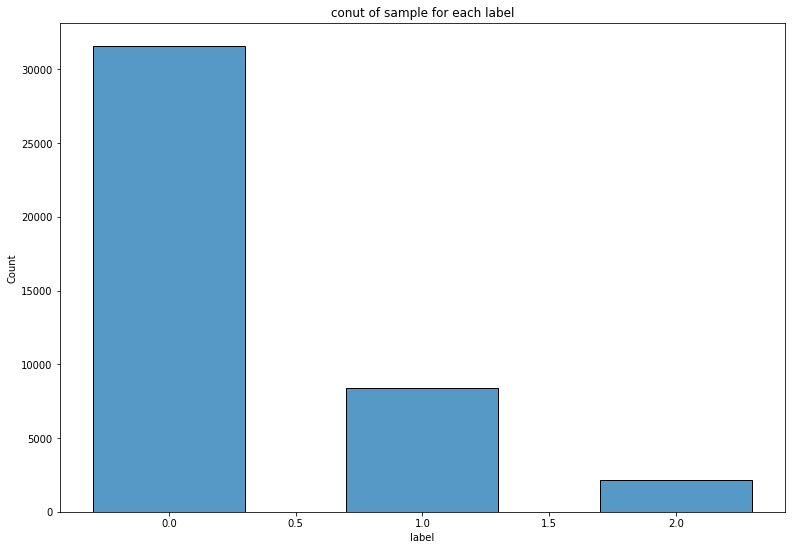

In [17]:
draw_hsitogram(y_pdf['label'], 'conut of sample for each label')

### Effectivness of OverSampleing 

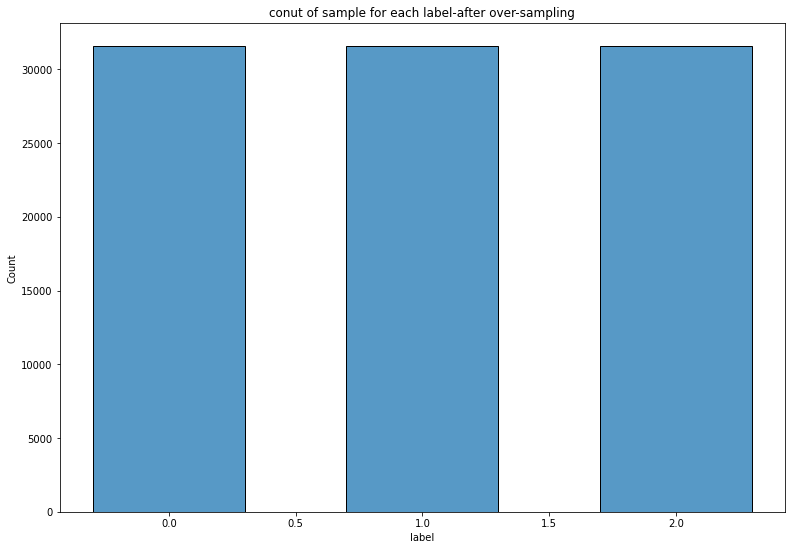

In [18]:
smote = SMOTE()

x_smote, y_smote = smote.fit_resample(x_pdf.drop('qid', axis=1), y_pdf.drop('qid', axis=1))
draw_hsitogram(y_smote['label'], 'conut of sample for each label-after over-sampling')

<font color='Red'>
    <div style=style="font-size: 25px"> 
        Result
    </div>
</font>

As you can see in the first histogram, most of the data labels are 0, and far fewer are 2. This will cause class imbalance. For this reason, we use oversampling to overcome the class imbalance problem.

As a result, <font color='Green'>we use over-sampling to overcome the class imbalance problem.</font>

## EDA Result

As we saw, we can use normalization and PCA algorithm for both part one and part two. In the first part, we suffer from class imbalance so, we will use oversampling to overcome this issue.

# Data Pre-Process

## Pre-Process Config

In [19]:
N_COMPONENTS = 30

## Normalization

In [20]:
def get_normalized_data(pdf):
    sc = StandardScaler()
    qid = pdf[['qid']]
    label = pdf[['label']]
    pdf = pdf.drop(['qid', 'label'], axis = 1)
    pdf = pca.fit_transform(pdf)
    pdf = pd.DataFrame(pdf)
    pdf['label'] = label
    pdf['qid'] = qid
    return pdf

norm_data_pdf = get_normalized_data(data_pdf)
summery(norm_data_pdf)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,label,qid
0,-1.056717,1.542904,0.007806,-0.108805,-0.314601,-0.614218,-0.247800,-0.113072,-0.103461,-0.047664,...,-0.008989,-0.005157,0.006816,-0.005086,-0.009465,0.002644,-0.002169,-0.001671,0,10
1,1.611046,-0.078157,0.294150,0.456564,-0.265912,-0.435449,0.318119,0.383160,0.493884,-0.112852,...,0.208717,-0.077813,0.108366,-0.089617,-0.079675,-0.217938,0.064956,-0.001958,1,10
2,0.352293,-0.217723,0.146690,-0.194997,-0.063894,0.222456,0.524858,0.150317,-0.539734,-0.371434,...,0.257621,-0.048215,0.105549,0.033576,0.013007,-0.046722,-0.037341,0.009231,1,10
3,2.964902,-0.430472,0.841555,0.540019,-0.228760,0.271971,0.356130,0.438707,-0.296200,-0.696096,...,0.353577,-0.041400,0.026521,-0.089434,0.099191,-0.072052,-0.022056,-0.001479,1,10
4,0.250382,0.026524,-0.217508,-0.681980,0.029534,-0.404783,0.356254,0.118874,-0.672296,-0.282198,...,0.071875,-0.006183,0.118695,0.045890,0.063105,-0.086413,-0.057315,-0.002936,0,10


## PCA

In [21]:
def get_reduced_feature(pdf, n_components=N_COMPONENTS):
    pca = PCA(n_components=n_components)
    qid = pdf[['qid']]
    label = pdf[['label']]
    pdf = pdf.drop(['qid', 'label'], axis = 1)
    pdf = pca.fit_transform(pdf)
    pdf = pd.DataFrame(pdf)
    pdf['label'] = label
    pdf['qid'] = qid
    return pdf

reduced_feature_pdf = get_reduced_feature(norm_data_pdf)
summery(reduced_feature_pdf)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,label,qid
0,-1.056717,1.542904,0.007806,-0.108805,-0.314601,-0.614218,-0.247800,-0.113072,-0.103461,-0.047664,...,-0.008989,-0.005157,0.006816,-0.005086,-0.009465,0.002644,-0.002169,-0.001671,0,10
1,1.611046,-0.078157,0.294150,0.456564,-0.265912,-0.435449,0.318119,0.383160,0.493884,-0.112852,...,0.208717,-0.077813,0.108366,-0.089617,-0.079675,-0.217938,0.064956,-0.001958,1,10
2,0.352293,-0.217723,0.146690,-0.194997,-0.063894,0.222456,0.524858,0.150317,-0.539734,-0.371434,...,0.257621,-0.048215,0.105549,0.033576,0.013007,-0.046722,-0.037341,0.009231,1,10
3,2.964902,-0.430472,0.841555,0.540019,-0.228760,0.271971,0.356130,0.438707,-0.296200,-0.696096,...,0.353577,-0.041400,0.026521,-0.089434,0.099191,-0.072052,-0.022056,-0.001479,1,10
4,0.250382,0.026524,-0.217508,-0.681980,0.029534,-0.404783,0.356254,0.118874,-0.672296,-0.282198,...,0.071875,-0.006183,0.118695,0.045890,0.063105,-0.086413,-0.057315,-0.002936,0,10


## Calculate Accuracy

In [22]:
def calculate_accuracy(y_pred_pdf, y_test_pdf):
    pdf = y_pred_pdf.rename({'label':'label_predicted'}, axis=1)
    pdf['label_true'] = y_test_pdf['label']
    wrong_predicted_pdf = pdf[pdf['label_true'] != pdf['label_predicted']]
    return 1 - len(wrong_predicted_pdf) / len(pdf)

# First Part

## Models

In [23]:
MODELS = ['CLOSED_FROM', 'DUMMY_MODEL', 'SIMPLE_MODEL', "BEST_MODEL"]

In [24]:
def get_best_scaler(y_train_pred, y_train):
    best_upper_bound = 2
    best_lower_bound = 0
    best_acc = 0
    for i in [x * 0.01 for x in range(100, 150)]:
        for j in [yy * 0.01 for yy in range(0, 100)]:
            y_scaled = [2 if y > i else 1 if y > j else 0 for y in y_train_pred]
            delta = np.array(y_scaled) - np.array(y_train)
            zeros = np.count_nonzero(delta==0)
            acc=zeros/len(delta)
            if acc > best_acc:
                best_acc = acc
                best_upper_bound = i
                best_lower_bound = j
    return best_upper_bound, best_lower_bound

### Closed From

In [25]:
def get_colsed_form_prediction(data_pdf, scale):
    norm_data_pdf = get_normalized_data(data_pdf)
    reduced_feature_pdf = get_reduced_feature(norm_data_pdf)
    x_matrix = reduced_feature_pdf.drop(['qid', 'label'], axis=1)
    x_matrix.insert(0, 'bias', 1)
    x_matrix = x_matrix.to_numpy()
    y_matrix = reduced_feature_pdf['label'].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(x_matrix, y_matrix, test_size=TEST_SIZE, random_state=RADNOM_STATE)
    weighted_matrix = np.dot(np.linalg.inv(np.dot(x_train.T, x_train)), np.dot(x_train.T, y_train))
    
    y_train_pred = np.dot(x_train, weighted_matrix)
    y_test_pred = np.dot(x_test, weighted_matrix)
    y_test_pred_pdf = pd.DataFrame(y_test_pred).rename({0:'label'}, axis=1)
    y_test_pdf = pd.DataFrame(y_test).rename({0:'label'}, axis=1)
    
    if scale:
        best_x, best_y = get_best_scaler(y_train_pred, y_train)
        y_categorized = [2 if y > best_x else 1 if y > best_y else 0 for y in y_test_pred]
        y_test_pred_pdf['label'] = y_categorized
    
    return y_test_pred_pdf, y_test_pdf

### Other

In [26]:
def get_dummy_model_prediction(data_pdf):
    labels_count = [
        len(data_pdf[data_pdf['label'] == 0]),
        len(data_pdf[data_pdf['label'] == 1]),
        len(data_pdf[data_pdf['label'] == 2])
    ]
    max_label_count = max(labels_count)
    most_commen_label = labels_count.index(max_label_count)
    return most_commen_label

def get_simple_model_prediction(x_train, x_test, y_train, y_test, scale, random_state=RADNOM_STATE):
    sgd_rgresssion = SGDRegressor(random_state=random_state)
    sgd_rgresssion.fit(x_train, y_train)
    y_pred = sgd_rgresssion.predict(x_test)
    y_pred_pdf = pd.DataFrame(y_pred)
    y_pred_pdf = y_pred_pdf.rename({0:'label'}, axis=1)
    if scale:
        y_train_pred = sgd_rgresssion.predict(x_train)
        best_x, best_y = get_best_scaler(y_train_pred, pd.DataFrame(y_train)['label'])
        y_categorized = [2 if y > best_x else 1 if y > best_y else 0 for y in y_pred]
        y_pred_pdf['label'] = y_categorized
    y_test_pdf = pd.DataFrame(y_test).reset_index(drop=True)
    return y_pred_pdf


def get_prediction_and_test(data_pdf, model, scale=True,
                            test_size=TEST_SIZE, random_state=RADNOM_STATE):
    
    if model == 'CLOSED_FROM':
        return get_colsed_form_prediction(data_pdf, scale)
    
    if model == 'BEST_MODEL':
        norm_data_pdf = get_normalized_data(data_pdf)
        reduced_feature_pdf = get_reduced_feature(norm_data_pdf)
        x_pdf = reduced_feature_pdf.drop(['qid', 'label'], axis = 1)
        y_pdf = reduced_feature_pdf['label']
        x_train, x_test, y_train, y_test = train_test_split(x_pdf , y_pdf, 
                                                            test_size=test_size, random_state=random_state)

        x_train, y_train = smote.fit_resample(x_train, y_train)
        sgd_rgresssion = SGDRegressor(random_state=random_state)
        sgd_rgresssion.fit(x_train, y_train)
        y_pred = sgd_rgresssion.predict(x_test)
        y_pred_pdf = pd.DataFrame(y_pred)
        y_pred_pdf = y_pred_pdf.rename({0:'label'}, axis=1)
        if scale:
            y_train_pred = sgd_rgresssion.predict(x_train)
            best_x, best_y = get_best_scaler(y_train_pred, y_train)
            y_categorized = [2 if y > best_x else 1 if y > best_y else 0 for y in y_pred]
            y_pred_pdf['label'] = y_categorized
        
        y_test_pdf = pd.DataFrame(y_test).reset_index(drop=True)
        
        return y_pred_pdf, y_test_pdf
    
    x_pdf = data_pdf.drop(['qid', 'label'], axis = 1)
    y_pdf = data_pdf[['label']]
    x_train, x_test, y_train, y_test = train_test_split(x_pdf , y_pdf, 
                                                        test_size=test_size, random_state=random_state) 
    
    if model == 'SIMPLE_MODEL':
        y_pred_pdf = get_simple_model_prediction(x_train, x_test, y_train, y_test, scale)
        
    if model == 'DUMMY_MODEL':
        most_commen_label = get_dummy_model_prediction(y_train)
        y_pred = np.empty(len(x_test))
        y_pred.fill(most_commen_label)
        y_pred_pdf = pd.DataFrame(y_pred)
        y_pred_pdf = y_pred_pdf.rename({0:'label'}, axis=1)
        
    y_test_pdf = pd.DataFrame(y_test).reset_index(drop=True)
        
    return y_pred_pdf, y_test_pdf

## Evaluation

In [27]:
for model in MODELS:
    y_pred_pdf, y_test_pdf = get_prediction_and_test(data_pdf, model)
    accuracy = calculate_accuracy(y_pred_pdf, y_test_pdf)
    print(f"accuracy for {model} = {accuracy}")

accuracy for CLOSED_FROM = 0.7561669829222011
accuracy for DUMMY_MODEL = 0.7535578747628083
accuracy for SIMPLE_MODEL = 0.7535578747628083
accuracy for BEST_MODEL = 0.519331119544592


<font color='Red'>
    <div style=style="font-size: 25px"> 
        Conclusion
    </div>
</font>

In the first part, we have implemented four different models. First, we used the Closed-form to calculate the optimum weights vector of linear regression. After that, we have three models; the Dummy model, the Simple model, and the Best model. The Dummy model constantly predicts the labels regarding the most frequent train label. The other two models are linear regression models. The Simple model trained on original data, but, Our Best model used data normalizing, feature reduction, and oversampling to achieve better generalization.
At the evaluation step, for the Dummy and the Simple models, we got the same accuracy as Closed-form. It's because of having a high percentage of 0s in train labels. Besides that, having less accuracy in our Best model compared to the other models doesn't necessarily mean that they are more powerful models to use. On the other hand, our Best model has better generalization due to oversampling and handles less probable data.

# Second Part

### Prepare DataSet

#### Convert Pandas Data Frame to PySpark Data Frame 

In [28]:
CLEAN_DATA_PATH = './reduced_feature_pdf.csv'

def write_pandas_data_frame(pdf, path=CLEAN_DATA_PATH):
    pdf.to_csv(path, index=False)

def read_clean_data_df(path=CLEAN_DATA_PATH):
    return spark.read.csv(path, header=True)


reduced_feature_pdf = get_reduced_feature(data_pdf)
    
write_pandas_data_frame(reduced_feature_pdf)
clean_data_df = read_clean_data_df()
clean_data_df.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- 2: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- 4: string (nullable = true)
 |-- 5: string (nullable = true)
 |-- 6: string (nullable = true)
 |-- 7: string (nullable = true)
 |-- 8: string (nullable = true)
 |-- 9: string (nullable = true)
 |-- 10: string (nullable = true)
 |-- 11: string (nullable = true)
 |-- 12: string (nullable = true)
 |-- 13: string (nullable = true)
 |-- 14: string (nullable = true)
 |-- 15: string (nullable = true)
 |-- 16: string (nullable = true)
 |-- 17: string (nullable = true)
 |-- 18: string (nullable = true)
 |-- 19: string (nullable = true)
 |-- 20: string (nullable = true)
 |-- 21: string (nullable = true)
 |-- 22: string (nullable = true)
 |-- 23: string (nullable = true)
 |-- 24: string (nullable = true)
 |-- 25: string (nullable = true)
 |-- 26: string (nullable = true)
 |-- 27: string (nullable = true)
 |-- 28: string (nullable = true)
 |-- 29: string (nu

#### Buliding Customized Data Frame

In [29]:
columns = clean_data_df.columns
columns.remove('qid')
clean_data_j_df = clean_data_df
for column in columns:
    clean_data_j_df = clean_data_j_df.withColumn(column, F.round(F.col(column).cast('float'), 7))
    clean_data_j_df = clean_data_j_df.withColumnRenamed(column, str(column + "_j"))
    
clean_data_i_df = clean_data_df
for column in columns:
    clean_data_i_df = clean_data_i_df.withColumn(column, F.round(F.col(column).cast('float'), 7))
    clean_data_i_df = clean_data_i_df.withColumnRenamed(column, str(column + "_i"))    

#### Convert PySpark Data Frame to Pandas Data Frame

In [30]:
part_two_data_pdf = (
    clean_data_i_df
    .join(clean_data_j_df.drop('index'), on='qid')
    .filter(F.col('label_i') != F.col('label_j'))
    .withColumn('label', F.when(F.col('label_i') > F.col('label_j'), F.lit(1)).otherwise(F.lit(0)))
    .drop('label_i', 'label_j', 'qid')
    .toPandas()
)
summery(part_two_data_pdf)

,0_i,1_i,2_i,3_i,4_i,5_i,6_i,7_i,8_i,9_i,...,21_j,22_j,23_j,24_j,25_j,26_j,27_j,28_j,29_j,label
0,-1.056717,1.542904,0.007806,-0.108805,-0.314601,-0.614218,-0.2478,-0.113072,-0.103461,-0.047664,...,0.026672,0.035257,-0.026566,0.099024,0.048289,-0.012059,-0.005195,-0.002878,0.001886,0
1,-1.056717,1.542904,0.007806,-0.108805,-0.314601,-0.614218,-0.2478,-0.113072,-0.103461,-0.047664,...,-0.032514,-0.010181,0.125824,0.017389,-0.071898,0.016806,0.020825,-0.002636,-0.006421,0
2,-1.056717,1.542904,0.007806,-0.108805,-0.314601,-0.614218,-0.2478,-0.113072,-0.103461,-0.047664,...,0.073673,0.333730,0.009107,0.084283,0.081716,-0.007206,-0.003738,-0.029266,-0.007074,0
3,-1.056717,1.542904,0.007806,-0.108805,-0.314601,-0.614218,-0.2478,-0.113072,-0.103461,-0.047664,...,0.028087,0.073016,-0.002840,0.112950,0.051774,-0.013672,-0.005325,-0.001095,-0.001373,0
4,-1.056717,1.542904,0.007806,-0.108805,-0.314601,-0.614218,-0.2478,-0.113072,-0.103461,-0.047664,...,-0.107958,0.135215,-0.159903,0.154537,0.094420,-0.018149,-0.011984,-0.011474,0.027534,0


## Model

In [35]:
def get_logestic_regression_prediction(part_two_data_pdf):
    logistic_x_data = part_two_data_pdf.drop('label', axis=1)
    logistic_y_data = part_two_data_pdf[['label']]

    logistic_x_train, logistic_x_test, logistic_y_train, logistic_y_test = train_test_split(logistic_x_data , logistic_y_data, test_size=0.20, random_state=42)


    sgd_rgresssion = LogisticRegression(random_state=42)
    sgd_rgresssion.fit(logistic_x_train, logistic_y_train)
    y_pred = sgd_rgresssion.predict(logistic_x_test)
    y_pred_pdf = pd.DataFrame(y_pred)
    y_pred_pdf = y_pred_pdf.rename(columns = {0:'label'})

    logistic_y_test_pdf = pd.DataFrame(logistic_y_test).reset_index(drop=True)

    return y_pred_pdf, logistic_y_test_pdf

## Evaluation

In [37]:
logistic_y_pred_pdf, logistic_y_test_pdf = get_logestic_regression_prediction(part_two_data_pdf)
print(f"accuracy for Logestic Regression Model = {calculate_accuracy(logistic_y_pred_pdf, logistic_y_test_pdf)}")

accuracy for Logestic Regression Model = 0.7077718838282219
